In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from collections import Counter
from scipy import stats
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
import matplotlib as matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# --------------------------------------------------------------------------------------------------------------

## **Import filtered DECIPHER dataset and create binary matrix**

### Import csv and subset

In [79]:
decipher = pd.read_csv('decipher_filtered.csv', header=0)
decipher_subset = decipher[["gene", "propagated_names"]]

### Create binary matrix representing each patient (by gene)

In [80]:
decipher_phenotypes = decipher_subset['propagated_names'].str.get_dummies('|')
decipher_binary_matrix = pd.concat([decipher_subset[['gene']], decipher_phenotypes], axis=1)
decipher_binary_matrix.set_index('gene', inplace=True)

### Calculate proportion of patients in each gene group (n>=3) with each phenotype

In [81]:
proportions = decipher_binary_matrix.groupby(decipher_binary_matrix.index).mean()
group_sizes = decipher_binary_matrix.groupby(decipher_binary_matrix.index).size()
valid_groups = group_sizes[group_sizes >= 3].index
proportions = proportions.loc[valid_groups]

### Convert proportions dataframe into gene group binary matrix with 30% cut-off

In [82]:
proportions = proportions.where(proportions > 0.3, 0).where(proportions <= 0.3, 1)

# --------------------------------------------------------------------------------------------------------------

# **Jaccard similarity and dendrogram**

### Calculate Jaccard similarity

In [83]:
# Calculate Jaccard similarity between patients
jaccard_similarity = pd.DataFrame(1-pairwise_distances(proportions.to_numpy(), metric='jaccard'))

# Set row and column index to gene names
jaccard_similarity.index = proportions.index
jaccard_similarity.columns = proportions.index

/Users/alicesmail/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### Create dendrogram

In [84]:
# Plot Dendrogram
plt.figure(figsize=(25, 5))
sns.set(font_scale=2, font="Galvji")
plt.style.use('ggplot')
linkage = hierarchy.linkage(jaccard_similarity, 'ward')
hierarchy.set_link_color_palette(['#ec726c', "#a3d0da", '#d4c32d', '#69af34', '#42968f', '#455986'])
hierarchy.dendrogram(linkage, labels=proportions.index, color_threshold=2, above_threshold_color='grey', leaf_font_size=20)
plt.axhline(y=2, c='grey', lw=1, linestyle='dashed')
plt.xticks(rotation=90)
plt.grid()
plt.close()

# --------------------------------------------------------------------------------------------------------------

# **Clustering**

In [85]:
# Perform clustering with the Jaccard similarity matrix
n_clusters = 3
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward').fit(jaccard_similarity)

# Get the cluster membership for each gene
labels = clustering.labels_ + 1
genes = proportions.index
gene_clusters = {gene: label for gene, label in zip(genes, labels)}

# Add the Cluster column to the proportions DataFrame and move it to position [1]
proportions.insert(0, "cluster", [gene_clusters[gene] for gene in proportions.index])

In [86]:
# Get list of genes in each cluster
clusters = {}
for gene, label in gene_clusters.items():
    if label in clusters:
        clusters[label].append(gene)
    else:
        clusters[label] = [gene]

for label, genes in clusters.items():
    print(f"Cluster {label}: {genes}")

Cluster 2: ['ARID1A', 'ARID1B', 'ARID2', 'ASXL1', 'ASXL3', 'AUTS2', 'BCL11A', 'KANSL1', 'KDM6A', 'KMT2A', 'KMT2B', 'KMT2D', 'SMARCA2', 'SMARCA4', 'SMARCB1', 'SMARCC2', 'USP7']
Cluster 1: ['ASXL2', 'BCL11B', 'BCOR', 'DPF2', 'HCFC1', 'PCGF2', 'SETD1B']
Cluster 3: ['CHD8', 'EZH2', 'KDM6B', 'KMT2C', 'MBD5', 'SETD1A']


### *-------------------------- Performed t-test on clusters and determined clusters 2 & 3 have an increased mean intracluster similarity score --------------------------*

# **Compare clusters to find comparatively enriched HPO terms**

### Assign cluster gene lists to objects

In [87]:
cluster_2 = clusters[2] 
cluster_3 = clusters[3]

### Find number of patients represented by each cluster

In [88]:
decipher_cluster_2 = decipher[decipher["gene"].isin(cluster_2)]
decipher_cluster_3 = decipher[decipher["gene"].isin(cluster_3)]

cluster_2_total_freq = (len(decipher_cluster_2))
cluster_3_total_freq = (len(decipher_cluster_3))

### Find unique HPO terms across both clusters

In [89]:
# Find frequency of all HPO terms in DECIPHER dataset
clusters_2_3_combined = pd.concat([decipher_cluster_2, decipher_cluster_3], axis=0)

# Unique HPO terms
all_terms_in_cluster_2_3 = set()
clusters_2_3_combined['propagated_names'].str.split("|").apply(all_terms_in_cluster_2_3.update)
all_terms_in_cluster_2_3 = list(all_terms_in_cluster_2_3)
freq_terms_in_cluster_2_3 = len(all_terms_in_cluster_2_3)

### Cluster 2 HPO frequencies

In [90]:
# Create list of hpo term strings for each patient
cluster_2_hpo = decipher_cluster_2["propagated_names"].tolist()

# Go through list of strings, to create list of lists
cluster_2_hpo_lists = []
for list_phenotypes in cluster_2_hpo:
    list_phenotypes = list_phenotypes.split('|')
    cluster_2_hpo_lists.append(list_phenotypes)

# Flatten the list of lists into a single list
cluster_2_flat_list = [item for sublist in cluster_2_hpo_lists for item in sublist]

# Count frequency of each term
cluster_2_freq_count = Counter(cluster_2_flat_list)

# Add frequency values for each term into dictionary
cluster_2_term_freq = {}
for term in all_terms_in_cluster_2_3:
    if term in cluster_2_freq_count:
        cluster_2_term_freq[term] = cluster_2_freq_count[term]
    else:
        cluster_2_term_freq[term] = 0

### Cluster 3 HPO frequencies

In [91]:
# Create list of hpo term strings for each patient
cluster_3_hpo = decipher_cluster_3["propagated_names"].tolist()

# Go through list of strings, to create list of lists
cluster_3_hpo_lists = []
for list_phenotypes in cluster_3_hpo:
    list_phenotypes = list_phenotypes.split('|')
    cluster_3_hpo_lists.append(list_phenotypes)

# Flatten the list of lists into a single list
cluster_3_flat_list = [item for sublist in cluster_3_hpo_lists for item in sublist]

# Count frequency of each term
cluster_3_freq_count = Counter(cluster_3_flat_list)

# Add frequency values for each term into dictionary
cluster_3_term_freq = {}
for term in all_terms_in_cluster_2_3:
    if term in cluster_3_freq_count:
        cluster_3_term_freq[term] = cluster_3_freq_count[term]
    else:
        cluster_3_term_freq[term] = 0

### Create dataframe from cluster 2 and 3 dictionaries

In [92]:
clusters_freq = pd.DataFrame({'hpo_term': list(cluster_2_term_freq.keys()), 'cluster_2_freq': list(cluster_2_term_freq.values()), 'cluster_3_freq': list(cluster_3_term_freq.values())})

### Fisher's exact test

In [93]:
for index, row in clusters_freq.iterrows():
    hpo_term = row["hpo_term"]
    cluster_2_freq = row["cluster_2_freq"]
    cluster_3_freq = row["cluster_3_freq"]
    contingency_arrays = np.array([[cluster_2_freq, cluster_3_freq], [cluster_2_total_freq-cluster_2_freq, cluster_3_total_freq-cluster_3_freq]])
    contingency_table = np.asmatrix(contingency_arrays)
    odd_ratio, p_value = stats.fisher_exact(contingency_table)
    clusters_freq.loc[index, "p_value"] = p_value
    clusters_freq.loc[index, "OR"] = odd_ratio

### Adjust p-values using Benjamini-Hochberg method

In [94]:
# Create list of p-values
p_values = list(clusters_freq["p_value"])

# Perform adjustment
stats = importr('stats')
adj_p_values = list(stats.p_adjust(FloatVector(p_values), method = 'BH'))

# Assign adjusted p-values to new column
clusters_freq["adj_p_value"] = adj_p_values

### Identify comparatively increased HPO terms in each cluster

In [95]:
# Filter for significant HPO terms
clusters_freq['significant'] = np.where(clusters_freq['adj_p_value']<0.05, "Y", "N")
clusters_freq_significant = clusters_freq[(clusters_freq['significant']=="Y")]

# Using OR split into HPO terms increased in each cluster 
increased_cluster_2 = clusters_freq_significant[(clusters_freq_significant["OR"]>1)]
increased_cluster_3 = clusters_freq_significant[(clusters_freq_significant["OR"]<1)]

### Create heatmap

/var/folders/hw/lt7xkjh55hz1_s2z24sn1srh0000gn/T/ipykernel_12809/296613723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  increased_cluster_2["cluster_2_percent"] = (increased_cluster_2["cluster_2_freq"])/cluster_2_total_freq
/var/folders/hw/lt7xkjh55hz1_s2z24sn1srh0000gn/T/ipykernel_12809/296613723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  increased_cluster_3["cluster_2_percent"] = (increased_cluster_3["cluster_2_freq"])/cluster_2_total_freq
/var/folders/hw/lt7xkjh55hz1_s2z24sn1srh0000gn/T/i

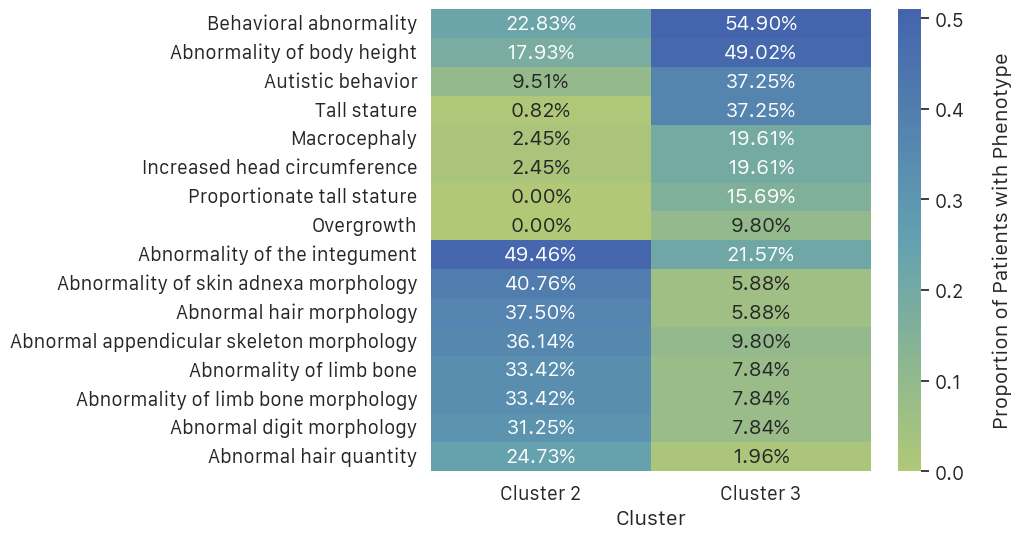

In [96]:
# Calculate percentages
increased_cluster_2["cluster_2_percent"] = (increased_cluster_2["cluster_2_freq"])/cluster_2_total_freq
increased_cluster_3["cluster_2_percent"] = (increased_cluster_3["cluster_2_freq"])/cluster_2_total_freq

increased_cluster_2["cluster_3_percent"] = (increased_cluster_2["cluster_3_freq"])/cluster_3_total_freq
increased_cluster_3["cluster_3_percent"] = (increased_cluster_3["cluster_3_freq"])/cluster_3_total_freq

# Combine top HPO terms and subset
cluster_2_3 = pd.concat([increased_cluster_2, increased_cluster_3], axis=0)
cluster_2_3_subset = cluster_2_3[["hpo_term", "cluster_2_percent", "cluster_3_percent"]]
cluster_2_3_subset = cluster_2_3_subset.rename(columns={"cluster_2_percent": "Cluster 2", "cluster_3_percent": "Cluster 3"})
cluster_2_3_subset = cluster_2_3_subset.set_index("hpo_term")

# Define the order of row labels
row_order = [
# Increased in cluster 3
"Behavioral abnormality",
"Abnormality of body height",
"Autistic behavior",
"Tall stature",
"Macrocephaly",
"Increased head circumference",
"Proportionate tall stature",
"Overgrowth",

# Increased in cluster 2
"Abnormality of the integument",
"Abnormality of skin adnexa morphology",
"Abnormal hair morphology",
"Abnormal appendicular skeleton morphology",
"Abnormality of limb bone",
"Abnormality of limb bone morphology",
"Abnormal digit morphology",
"Abnormal hair quantity",
]

cluster_2_3_subset.index = pd.Categorical(cluster_2_3_subset.index, categories=row_order, ordered=True)
cluster_2_3_subset = cluster_2_3_subset.sort_index()

# Heatmap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom blue', 
                                             [(0,    '#B1C877'),
                                              (0.5, '#63A1B0'),
                                              (1,    '#4464AD')], N=256)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.set(font_scale=1.2, font="Galvji")
heatmap = sns.heatmap(cluster_2_3_subset, cmap=cmap, cbar=True, annot=True, vmin=0.0, vmax=0.51, fmt=".2%")
cbar = heatmap.collections[0].colorbar
cbar.set_label('\nProportion of Patients with Phenotype')
plt.subplots_adjust(left=0.4, right=0.95)
plt.xlabel("Cluster")
plt.show()


# --------------------------------------------------------------------------------------------------------------